In [33]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.preprocessing import image    
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
df = pd.read_csv('../data/interim/file_dataframe.csv')
df.head()

,file_path,category
0,../data/raw/AID/Pond/pond_251.jpg,Pond
1,../data/raw/AID/Pond/pond_245.jpg,Pond
2,../data/raw/AID/Pond/pond_24.jpg,Pond
3,../data/raw/AID/Pond/pond_30.jpg,Pond
4,../data/raw/AID/Pond/pond_18.jpg,Pond


In [3]:
le = LabelEncoder()
y = le.fit_transform(df['category'])
x = df['file_path']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

In [5]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)              

# pre-process the data for Keras
train_tensors = paths_to_tensor(x_train).astype('float32')/255
valid_tensors = paths_to_tensor(x_test).astype('float32')/255

100%|██████████████████████████████████████| 1999/1999 [00:12<00:00, 162.90it/s]


In [6]:
img_width, img_height = 224,224
channels = 3
VGG_model = applications.VGG19(weights= 'imagenet', include_top = False, input_shape = (img_width, img_height, channels))

###Freeze VGG Layers
for layer in VGG_model.layers[:17]:
    layer.trainable = False

2022-08-03 11:05:43.937109: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 11:05:43.937456: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
num_classes = 30

x = VGG_model.output
#x = Dropout(0.4)(x)
x = Activation('relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model_final = Model(VGG_model.input, predictions)

In [13]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [14]:
model_final.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [15]:
checkpoint = ModelCheckpoint('sat_model.hdf5', monitor = 'val_loss', save_best_only = True, verbose = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience= 3, min_lr=0.00001, verbose = 1)
early_stop = EarlyStopping(monitor= 'val_loss', min_delta=0, patience=7)
callbacks_list = [checkpoint, reduce_lr, early_stop]

In [16]:
hist = model_final.fit(train_tensors, y_train, batch_size = 128, callbacks = callbacks_list, epochs=30,
                       validation_split=0.1)

Train on 7195 samples, validate on 800 samples
Epoch 1/30
7168/7195 [============================>.] - ETA: 15s - loss: 1.4522 - accuracy: 0.5844 
Epoch 00001: val_loss improved from inf to 0.87987, saving model to sat_model.hdf5
7195/7195 [==============================] - 4687s 651ms/sample - loss: 1.4512 - accuracy: 0.5846 - val_loss: 0.8799 - val_accuracy: 0.7275
Epoch 2/30
7168/7195 [============================>.] - ETA: 15s - loss: 0.6518 - accuracy: 0.7966 
Epoch 00002: val_loss improved from 0.87987 to 0.74771, saving model to sat_model.hdf5
7195/7195 [==============================] - 4687s 651ms/sample - loss: 0.6515 - accuracy: 0.7968 - val_loss: 0.7477 - val_accuracy: 0.7663
Epoch 3/30
7168/7195 [============================>.] - ETA: 16s - loss: 0.4973 - accuracy: 0.8499 
Epoch 00003: val_loss improved from 0.74771 to 0.71578, saving model to sat_model.hdf5
7195/7195 [==============================] - 4702s 654ms/sample - loss: 0.4975 - accuracy: 0.8499 - val_loss: 0.7158

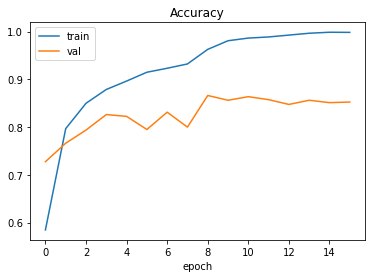

In [19]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

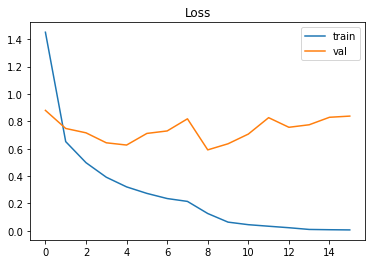

In [20]:
plt.title('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [23]:
preds = model_final.predict(valid_tensors)

In [27]:
pred_max = [np.argmax(p) for p in preds]

In [37]:
accuracy_score(pred_max, y_test)

0.8519259629814907

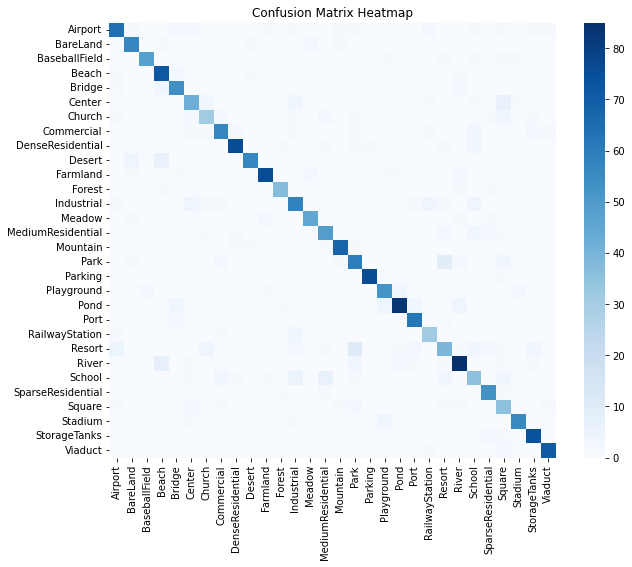

In [53]:
plt.figure(figsize = (10,8))
labels = le.inverse_transform(np.arange(30))
cm = confusion_matrix(pred_max, y_test)
sn.heatmap(cm, cmap = 'Blues', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix Heatmap');